<a href="https://colab.research.google.com/github/LACDR-CDS/SCDR_RNAseq/blob/main/Session3and4/group7_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3 & 4
In the last session, you learned the basic processing steps for RNA sequencing data. Now you will do the next steps in the analysis of transcriptomics data to investigate the transcriptional impact of a GATA4 mutation on human cardiomyocyte differentiation.

## Background
Mutations in **GATA4**, a key transcription factor in heart development, are linked to **congenital heart defects** and **cardiomyopathy**.  
To investigate the molecular basis, you will compare **isogenic wildtype** and **GATA4-G296S mutant** cells at different stages of cardiomyocyte differentiation using RNA-seq.  

## Objectives

1. Explore whether GATA4 mutation alters global gene expression patterns (PCA).  
2. Identify differentially expressed genes (DEGs) between mutant and WT at each stage.  
3. Visualize DEGs with volcano plots and heatmaps.  
4. Perform GO enrichment to determine affected biological pathways.  
5. Interpret whether the mutation leads to loss of cardiomyocyte identity and/or gain of non-cardiac programs.  

## Setup

Run the following cells to set up the necessary packages and download the data. If you wish to use a package which is not in the list below, you will need to install and import it yourself.

In [ ]:
#Install packages which are not in the default environment
%pip install scanpy
%pip install pydeseq2
%pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 16.3 MB/s eta 0:00:00


In [ ]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle
import gseapy
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
group_number = 7

In [ ]:
#Make data directory if it does not exist
os.makedirs("data", exist_ok=True)
os.makedirs("plots", exist_ok=True)

#Download datasets in the data folder
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group{group_number}_counts.txt -O data/group{group_number}_counts.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group{group_number}_metadata.csv -O data/group{group_number}_metadata.csv

--2025-11-19 12:25:22--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group7_counts.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 845828 (826K) [text/plain]
Saving to: ‘data/group7_counts.txt’

data/group7_counts. 100%[===================>] 826.00K  --.-KB/s    in 0.03s   

2025-11-19 12:25:22 (28.6 MB/s) - ‘data/group7_counts.txt’ saved [845828/845828]

--2025-11-19 12:25:22--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/group7_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

## Data import
Read the count matrix.
- How many samples and genes do you have?

Read the corresponding metadata table.
- Which differentiation day do the samples belong to?

**Solution**<br/>
The samples belong to differentiation day 7.
There are 4 samples (2 wildtype, 2 mutant) and 42833 genes.

### ANSWER CODE

In [ ]:
# Load data
counts = pd.read_csv("data/group7_counts.txt", sep="\t", index_col=0)
metadata = pd.read_csv("data/group7_metadata.csv")
metadata.index=metadata['sample_id']
print(counts)
metadata

             day7_rep1_wt  day7_rep2_wt  day7_rep1_mut  day7_rep2_mut
DDX11L1                 0             0              0              0
WASH7P                 12            13             17             12
MIR6859-1               0             0              0              0
MIR1302-2HG             0             0              0              0
MIR1302-2               0             0              0              0
...                   ...           ...            ...            ...
ND6                     0          1649           2811           2061
TRNE                    0             0              0              0
CYTB                    0         33536          32601          31785
TRNT                    0             0              0              0
TRNP                    0            33             57             30

[42844 rows x 4 columns]


,sample_id,day,replicate,stage,cell_line,condition
sample_id,,,,,,
day7_rep1_wt,day7_rep1_wt,7,1,cardiac progenitor,hiPSC,isogenic wildtype
day7_rep2_wt,day7_rep2_wt,7,2,cardiac progenitor,hiPSC,isogenic wildtype
day7_rep1_mut,day7_rep1_mut,7,1,cardiac progenitor,hiPSC,missense mutation
day7_rep2_mut,day7_rep2_mut,7,2,cardiac progenitor,hiPSC,missense mutation


## Filtering
Filter the data to remove genes with less than 10 reads over all samples.
- How many genes are left in the count table after filtering?

**Solution**<br/>
There are 21074 genes left after filtering.

### ANSWER CODE

In [ ]:
counts = counts[counts.sum(axis=1) >= 10]
print(counts)

              day7_rep1_wt  day7_rep2_wt  day7_rep1_mut  day7_rep2_mut
WASH7P                  12            13             17             12
LOC124900384             1             4              3              4
LOC729737              129           140            143            132
DDX11L17                 2             4              3              4
LOC100996442             7             3             14              3
...                    ...           ...            ...            ...
ND4                      1         36765          38644          35908
ND5                      0         30447          27819          24371
ND6                      0          1649           2811           2061
CYTB                     0         33536          32601          31785
TRNP                     0            33             57             30

[21074 rows x 4 columns]


## Normalization: counts per million
Perform normalization to account for differences in sequencing depth among samples.

### ANSWER CODE

In [ ]:
total_reads = counts.sum(axis = 0)
normalized_count_table = (counts / total_reads) * 1e6
log_transformed_counts = np.log2(normalized_count_table + 1)

## Principle component analysis (PCA)

Now explore your data with PCA like you did in the previous session. Plot the first two principal components, use the seaborn package.
- Does the mutation have any effect on gene expression or do all samples cluster together?
- Do you think the samples of the isogenic wildtype are perfect replicates? What about the missense mutation?

**Solution**<br/>
The mutation has an effect on gene expression, as the PCA plot shows that the wildtype and mutant samples cluster separately. However, there is also quite a transcriptional difference between the two wildtype samples, which makes them less reliable as replicates. The missense mutation samples cluster a lot closer together, which makes them better replicates.

### ANSWER CODE

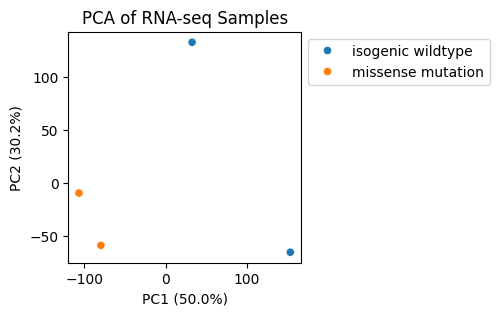

In [ ]:
scaler = StandardScaler()
scaled_table = scaler.fit_transform(log_transformed_counts.T)
pca = PCA()
pca_result_matrix = pca.fit_transform(scaled_table)
np.shape(pca_result_matrix)

plot_df = pd.DataFrame({
 "PC1": pca_result_matrix[:, 0],
 "PC2": pca_result_matrix[:, 1],
 "condition": metadata["condition"].values
})

plt.figure(figsize=(3, 3))

sns.scatterplot(
data=plot_df,
x="PC1", y="PC2",
hue="condition"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Differential gene expression

Now you can perform differential gene expression analysis using the DEseq2 method. This method allows to find genes with significant expression differences (up- or downregulated) between two conditions.
- Your goal is to investigate the effect of the mutation on cardiomyocyte differentiation. Which samples do you need to compare?
- Build your DEseq object(s) and run the analysis. *Make sure you use the raw filtered counts for this (not the counts per million normalized counts used for PCA), since DEseq does it's own internal normalization method.*
- Look at the results of you analysis. What information do the rows and columns of the DEseq result mean?

**Solution**<br/>
We need to compare the missense mutation with the isogenic wildtype. The rows are the gene names and the columns show the statistical differential expression results.
- baseMean: mean normalized expression across all samples.
- log2FoldChange: log₂ of the estimated fold change between conditions.
- lfcSE: standard error of the log2FoldChange estimate.
- stat: Wald test statistic (log2FoldChange / lfcSE).
- pvalue: p-value for H₀: log2FoldChange = 0.
- padj: p-value adjusted for multiple testing (FDR, e.g. Benjamini–Hochberg).

### ANSWER CODE

In [ ]:
dds = DeseqDataSet(counts=counts.T, metadata= metadata, design_factors="condition")
dds.deseq2()
stat_res = DeseqStats(
    dds,
    contrast=("condition","missense mutation","isogenic wildtype")
)
stat_res.summary()
res_df = stat_res.results_df

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 30.19 seconds.

Fitting dispersion trend curve...
... done in 1.62 seconds.

Fitting MAP dispersions...
... done in 51.77 seconds.

Fitting LFCs...
... done in 17.26 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 8.65 seconds.



Log2 fold change & Wald test p-value: condition missense mutation vs isogenic wildtype
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P           13.427176        0.152786  0.758227  0.201504  0.840304   
LOC124900384      2.955033        0.422653  1.232523  0.342917  0.731661   
LOC729737       135.235521       -0.032268  0.517088 -0.062402  0.950242   
DDX11L17          3.213133        0.156952  1.130641  0.138817  0.889595   
LOC100996442      6.750211        0.711019  1.260028  0.564288  0.572558   
...                    ...             ...       ...       ...       ...   
ND4           27336.944588        0.976575  2.719943  0.359042  0.719563   
ND5           20325.642801        0.735173  3.164259  0.232336  0.816277   
ND6            1600.887848        1.523544  2.791598  0.545761  0.585230   
CYTB          24047.308697        0.896939  3.174634  0.282533  0.777535   
TRNP             29.554604        1.363642  2.082067  0.654946  0.512502   



- Now get the significantly upregulated and downregulated genes from this dataframe with a log2 fold change bigger than 2. Are there more genes that are upregulated or downregulated? _Tip: to get an overview in one figure, you can plot the upregulated and downregulated genes in a volcano plot._

**Solution**<br/>
There are more genes upregulated (166) than downregulated (89).

### ANSWER CODE

In [ ]:
upregulated_genes = res_df[(res_df["log2FoldChange"] > 2) & (res_df["padj"] < 0.05)]
upregulated_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FCN3,27.729293,3.855624,1.089978,3.537341,4.041775e-04,2.972367e-02
LAPTM5,54.645931,3.133606,0.654832,4.785358,1.706826e-06,4.914502e-04
GJA4,58.463223,3.314848,0.700408,4.732736,2.215135e-06,5.879798e-04
TIE1,74.846840,4.319730,0.769819,5.611358,2.007447e-08,1.136750e-05
TAL1,188.290665,4.289451,0.592866,7.235116,4.651331e-13,1.128811e-09
...,...,...,...,...,...,...
SAMSN1,27.100349,4.337843,1.047557,4.140916,3.459224e-05,4.485900e-03
ERG,145.746763,4.400368,0.712381,6.176988,6.533594e-10,8.537900e-07
PDGFB,52.793405,2.809843,0.732081,3.838158,1.239607e-04,1.210255e-02
KLHDC7B,73.745611,2.371207,0.706041,3.358454,7.837971e-04,4.614110e-02


In [ ]:
downregulated_genes = res_df[(res_df["log2FoldChange"] < -2) & (res_df["padj"] < 0.05)]
downregulated_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CASZ1,137.303227,-2.165019,0.544642,-3.975120,7.034391e-05,0.007806
PAX7,18.806245,-4.636432,1.115366,-4.156869,3.226387e-05,0.004282
TRABD2B,353.552379,-3.060543,0.507824,-6.026774,1.672641e-09,0.000001
LINC02794,54.431731,-2.208993,0.638618,-3.459019,5.421462e-04,0.036118
VCAM1,29.319229,-4.257486,0.959867,-4.435494,9.186136e-06,0.001643
...,...,...,...,...,...,...
ZNF585A,43.477280,-8.926714,2.527573,-3.531733,4.128465e-04,0.029975
RSPO4,138.702807,-2.616932,0.587514,-4.454247,8.418815e-06,0.001555
COL6A1,3321.861183,-2.240116,0.487671,-4.593501,4.358700e-06,0.000987
COL6A2,1125.548221,-2.061893,0.493035,-4.182045,2.888991e-05,0.004051


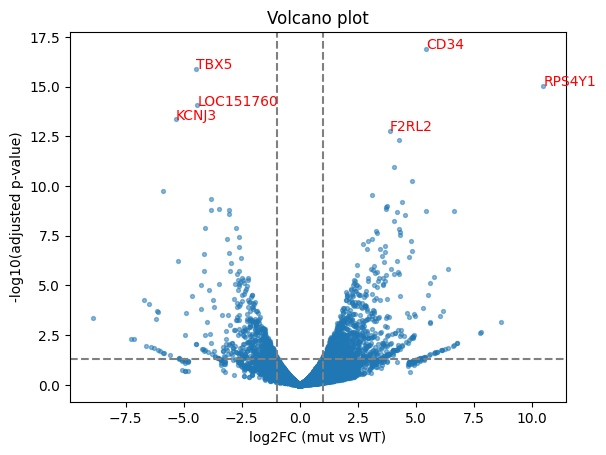

In [ ]:
plt.scatter(res_df.log2FoldChange, -np.log10(res_df.pvalue), s=8, alpha=0.5)

plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")

plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(adjusted p-value)")
plt.title(f"Volcano plot")

up = res_df[res_df.log2FoldChange > 1].nsmallest(3, "pvalue")
down = res_df[res_df.log2FoldChange < -1].nsmallest(3, "pvalue")

for gene, r in up.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.pvalue), gene,
  fontsize=10, color="red")
for gene, r in down.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.pvalue), gene,
  fontsize=10, color="red")

plt.show()


- Take the dataframe of your DESeq2 results (res_df) and sort the values by the significant p-adjusted value (padj). Then take the top 10 genes names from the sorted dataframe (_hint: top10 = res_df.head(10).index_). What are the top 3 gene names?

**Solution**<br/>
The top 3 differentially expressed genes are CD34, TBX5 and RSP4Y1.

### ANSWER CODE

In [ ]:
res_df = res_df.sort_values('padj')
top10 = res_df.head(10).index
top10

Index(['CD34', 'TBX5', 'RPS4Y1', 'LOC151760', 'KCNJ3', 'F2RL2', 'TAL1', 'CDH5',
       'CD93', 'WNT1'],
      dtype='object')

- Now plot the top 10 differentially expressed genes. Which gene is downregulated the most due to the GATA4 mutation? Can you find any support in literature how this gene is connected to GATA4?
<details>
<summary>💡 Show solution</summary>

TBX5 is a transcription factor that causes septal defects when mutated. GATA4 normally co-occupies cardiac enhancers with TBX5, another cardiac transcription factor. The G296S mutation disrupts TBX5 recruitment, especially at super-enhancers.
- https://doi.org/10.1016/j.cell.2016.11.033

### ANSWER CODE

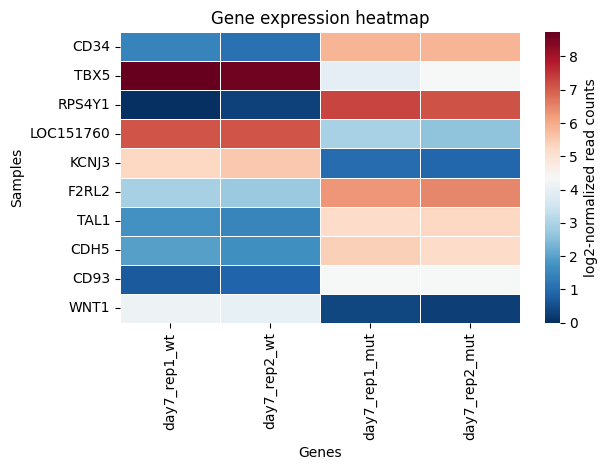

In [ ]:
sns.heatmap(
log_transformed_counts.loc[top10],
cmap="RdBu_r",
linecolor = "white",
linewidth = 0.5,
cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Gene expression heatmap")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()


# Gene Ontology enrichment

Now, you can start interpreting the lists of genes you get from the DEseq analysis and learn if there are any biological pathways that are effected by the GATA4 mutation.
- Use the cheat sheet to perform a GO enrichment analysis on the upregulated and downregulated genes. Which biological processes are downregulated in mutant vs WT at this day?
- Can you find scientific evidence in literature that these processes are regulated by GATA4?

**Solution**<br/>
Biological processes that are downregulated are mostly related to cardiac conduction, in which TBX5 plays an essential role. The G296S mutation disrupts TBX5 recruitment, leading to downregulation of cardiac programs (e.g., contraction, calcium handling, septation) and aberrant activation of endothelial/endocardial pathways.

- https://doi.org/10.1038/nature01827
- https://doi.org/10.1016/bs.ctdb.2016.08.008
- https://doi.org/10.1016/j.cell.2016.11.033

### ANSWER CODE

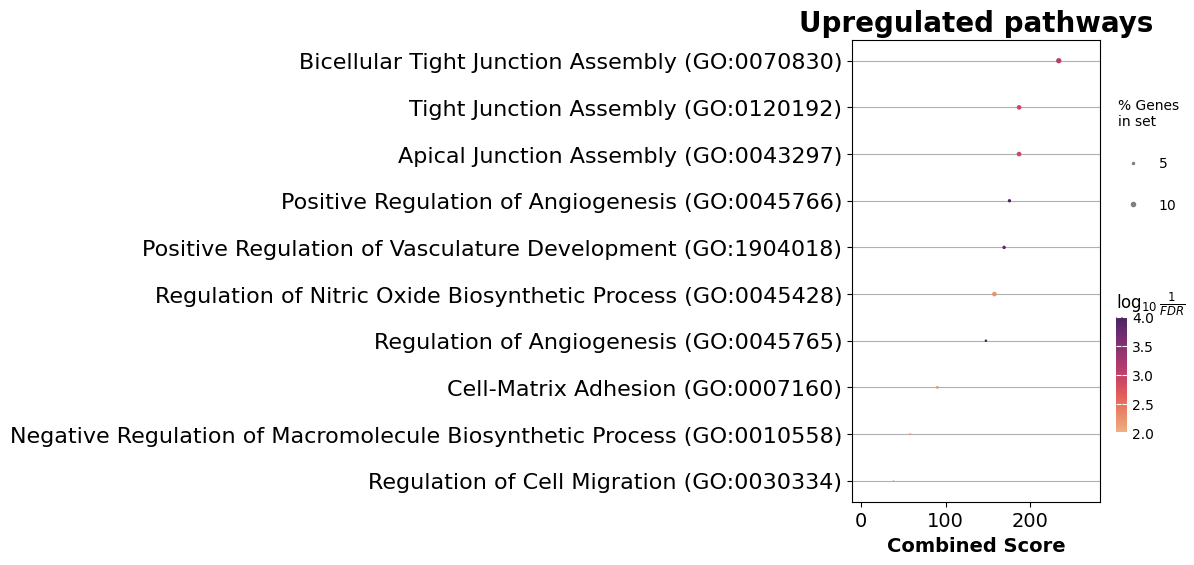

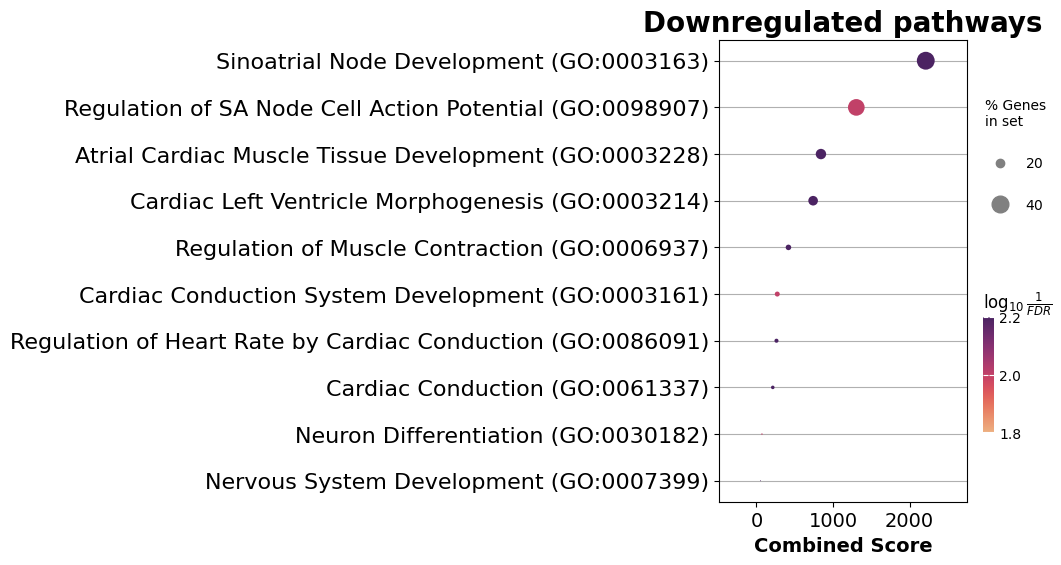

In [ ]:
up   = upregulated_genes.index.tolist()
down = downregulated_genes.index.tolist()

enr_up = gseapy.enrichr(up,
                        gene_sets=["GO_Biological_Process_2025"],
                        organism="Human", cutoff=0.05)
gseapy.plot.dotplot(enr_up.res2d, title=f"Upregulated pathways", cmap="flare", top_term=10)
plt.show()

enr_down = gseapy.enrichr(down,
                          gene_sets=["GO_Biological_Process_2025"],
                          organism="Human", cutoff=0.05)
gseapy.plot.dotplot(enr_down.res2d, title=f"Downregulated pathways", cmap="flare", top_term=10)
plt.show()